In [1]:
%pip install git+https://github.com/cioos-siooc/ocean-data-parser.git

%pip install folium 
%pip install plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/HakaiInstitute/ocean-data-parser.git to /tmp/pip-req-build-115vqbh6
  Running command git clone -q https://github.com/HakaiInstitute/ocean-data-parser.git /tmp/pip-req-build-115vqbh6
  Created wheel for ocean-data-parser: filename=ocean_data_parser-0.1.0-py3-none-any.whl size=42111 sha256=d15df3d587f429752eb3cb52029dee7ef5b5d868dc97e03dc38016af7bb2cee5
  Stored in directory: /tmp/pip-ephem-wheel-cache-4h9jxxdz/wheels/da/13/ab/3935dafef906d730e8b8408501739fcba46984c1d62b638d10
Successfully built ocean-data-parser


In [9]:
from ocean_data_parser.parsers import nmea
import pandas as pd
from glob import glob
from tqdm import tqdm
import os
import requests
import folium

import numpy as np


# Download test data 
NMEA test data is available here:

https://github.com/HakaiInstitute/ocean-data-parser/tree/main/tests/parsers_test_files/nmea

In [10]:
# retrieve raw data

def download_file_from_github(raw_url):
    """Download a github raw file localy"""
    file_path = os.path.basename(raw_url)
    response = requests.get(raw_url)
    with open(file_path, "w") as f:
        f.write(response.text)
    return file_path

nmea_files = ["https://raw.githubusercontent.com/cioos-siooc/ocean-data-parser/development/tests/parsers_test_files/nmea/seaspan/nmeadata-2022-07-04_00.txt",
"https://raw.githubusercontent.com/cioos-siooc/ocean-data-parser/development/tests/parsers_test_files/nmea/seaspan/nmeadata-2022-07-04_01.txt",
"https://raw.githubusercontent.com/cioos-siooc/ocean-data-parser/development/tests/parsers_test_files/nmea/seaspan/nmeadata-2022-07-04_02.txt",
"https://raw.githubusercontent.com/cioos-siooc/ocean-data-parser/development/tests/parsers_test_files/nmea/seaspan/nmeadata-2022-07-04_03.txt"]

files = [download_file_from_github(file) for file in nmea_files]

# Read NMEA file

## Parse NMEA to a table format

In [11]:
nmea_files = glob("nmeadata-*.txt")
nmea_parsed = [
    nmea.file(file).to_dataframe()
    for file in tqdm(nmea_files, desc="Import nmea files", unit="file")
]
# Aggregate all files
df = pd.concat(nmea_parsed)
df


Import nmea files: 100%|██████████| 4/4 [00:00<00:00,  4.88file/s]


,row,prefix,talker,sentence_type,subtype,manufacturer,b_pressure_inch,inches,b_pressure_bar,bars,...,mag_var_dir,latitude_degrees_north,longitude_degrees_east,gps_datetime,wind_angle,reference,wind_speed,wind_speed_units,wind_speed_relative_to_platform_knots,wind_direction_relative_to_platform
index,,,,,,,,,,,,,,,,,,,,,
0,0.0,20220704 020001+00:00,II,MDA,None,None,29.9,I,1.011,B,...,None,NaN,NaN,NaT,NaN,None,NaN,None,NaN,NaN
1,1.0,20220704 020001+00:00,HC,HDT,None,None,NaN,None,NaN,None,...,None,NaN,NaN,NaT,NaN,None,NaN,None,NaN,NaN
2,2.0,20220704 020001+00:00,GP,RMC,None,None,NaN,None,NaN,None,...,E,49.64816,-126.09383,2022-07-04 01:59:56,NaN,None,NaN,None,NaN,NaN
3,3.0,20220704 020001+00:00,WI,MWV,None,None,NaN,None,NaN,None,...,None,NaN,NaN,NaT,279.59,R,4.20,N,4.20,279.59
4,4.0,20220704 020003+00:00,II,MDA,None,None,29.9,I,1.011,B,...,None,NaN,NaN,NaT,NaN,None,NaN,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7195,7195.0,20220704 005957+00:00,WI,MWV,None,None,NaN,None,NaN,None,...,None,NaN,NaN,NaT,337.69,R,0.89,N,0.89,337.69
7196,7196.0,20220704 005959+00:00,II,MDA,None,None,29.8,I,1.010,B,...,None,NaN,NaN,NaT,NaN,None,NaN,None,NaN,NaN
7197,7197.0,20220704 005959+00:00,HC,HDT,None,None,NaN,None,NaN,None,...,None,NaN,NaN,NaT,NaN,None,NaN,None,NaN,NaN


## Convert prefix of NMEA to datetime

In [12]:
# In this case the each rows prefix prior to the NMEA string is a timestamp, convert it to a datetime object
df["computer_time"] = pd.to_datetime(df["prefix"])


# Reseample NMEA data to 2s

In [13]:
# Use the prefix timestamp as an index and resample the data to a 5 min interval and keep the first good value
df_resampled = df.set_index("computer_time").resample("2s").first()
df_resampled.head()


,row,prefix,talker,sentence_type,subtype,manufacturer,b_pressure_inch,inches,b_pressure_bar,bars,...,mag_var_dir,latitude_degrees_north,longitude_degrees_east,gps_datetime,wind_angle,reference,wind_speed,wind_speed_units,wind_speed_relative_to_platform_knots,wind_direction_relative_to_platform
computer_time,,,,,,,,,,,,,,,,,,,,,
2022-07-04 00:00:00+00:00,0.0,20220704 000001+00:00,II,MDA,None,None,29.8,I,1.01,B,...,E,49.64833,-126.0935,2022-07-03 23:59:56,284.59,R,2.68,N,2.68,284.59
2022-07-04 00:00:02+00:00,4.0,20220704 000003+00:00,II,MDA,None,None,29.8,I,1.01,B,...,E,49.64833,-126.0935,2022-07-03 23:59:58,286.10,R,3.89,N,3.89,286.10
2022-07-04 00:00:04+00:00,8.0,20220704 000005+00:00,II,MDA,None,None,29.8,I,1.01,B,...,E,49.64833,-126.0935,2022-07-04 00:00:00,293.89,R,3.38,N,3.38,293.89
2022-07-04 00:00:06+00:00,12.0,20220704 000007+00:00,II,MDA,None,None,29.8,I,1.01,B,...,E,49.64833,-126.0935,2022-07-04 00:00:02,317.89,R,1.59,N,1.59,317.89
2022-07-04 00:00:08+00:00,16.0,20220704 000009+00:00,II,MDA,None,None,29.8,I,1.01,B,...,E,49.64833,-126.0935,2022-07-04 00:00:04,276.99,R,2.10,N,2.10,276.99


# Plot Resulting Data

array([<AxesSubplot:xlabel='Time'>, <AxesSubplot:xlabel='Time'>,
       <AxesSubplot:xlabel='Time'>], dtype=object)

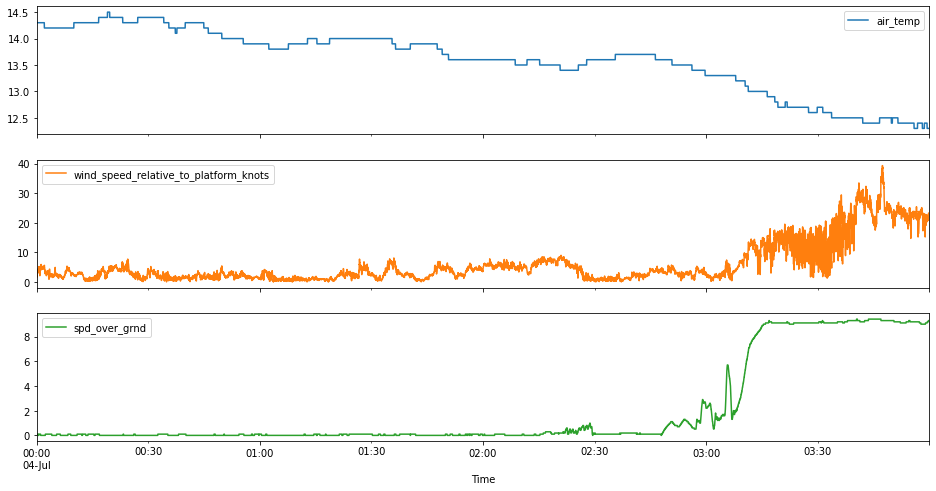

In [21]:
# Plot data
df_resampled[
    [
        "air_temp",
        "wind_speed_relative_to_platform_knots",
        "spd_over_grnd",
    ]
].plot(xlabel="Time", figsize=(16, 8), subplots=True)


# Plot position on a map

In [19]:
# Plot lat/lon on a map
lat, lon = "latitude_degrees_north", "longitude_degrees_east"
map = folium.Map(location=df_resampled[[lat, lon]].mean(), zoom_start=10)
folium.PolyLine(df_resampled[[lat, lon]].dropna().values, color="red").add_to(map)
map
